# SIR model

In {cite}`Chunhua@2014` the following SIR model is considered

$$
\begin{cases}
\begin{aligned}
    \frac{d S}{d t} &=A-d S-\frac{\beta S I}{S+I+R}, \\ 
    \frac{d I}{d t} &=-(d+\nu) I-\mu(b,I) I+\frac{\beta S I}{S+I+R}, \\ 
    \frac{d R}{d t} &=\mu(b,I) I-d R,
\end{aligned}
\end{cases}
$$

where $A>0$ is the recruitment rate of susceptible population;
$d>0$ is the per capita natural death rate of the population; $\nu>0$ is
the per capita disease-induced death rate; $\mu>0$ is the per capita
recovery rate of infectious individual. The funtion $\mu$ is set to

$$
\mu(b,I) = \mu_0 + (\mu_1 - \mu_0) \frac{b}{I+b}.
$$

## Overview

In this demo we will 

- Compute a curve of equilibria, parametrized by $b$.
- Detect a Hopf and limit point.
- Start continuation form the Hopf point in two parameters $(\mu_1, b)$.
- Detect a Bogdanov-Takens points.
- Start continuation form the Bogdanov-Takens points in two parameters $(\mu_1, b)$.
- Compare the predicted and computed homoclinic bifurcation curve emanating
  from the Bogdanov-Takens point in parameters space.
- Compare a range of predictors for the homoclinic solutions emanating from the
  Bogdanov-Takens point with the corrected homoclinic solutions curve in
  phase-space.
- Create a convergence plot comparing the different homoclinic approximations
  derived in {cite}`Bosschaert@2021`.

## Load MatCont

Before we can start using __MatCont__ we need to add the main directory of
__MatCont,__ as well as various subdirectories of __MatCont,__ to the _MATLAB
search path_. This is done in the code below. The variable `matcont_home`
should point to the main directory of __MatCont.__

In [1]:
clear all
matcontpath = '../';
addpath(matcontpath)
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'Utilities'])
set(groot, 'defaultTextInterpreter', 'LaTeX');
set(0,'defaultAxesFontSize',15)

## Set the odefile

Next we set the variable `odefile` to the _system file_ previously generated by
the notebook [SIRmodel.ipynb](./SIRmodel.ipynb).

In [2]:
odefile=@SIRmodel;

## Define equilibrium

As in {cite}`Chunhua@2014` we fix the parameters $A = 20, \mu_0 = 10, d = 1/10, \nu = 1,$ 
and $\beta = 11.5$.

In [3]:
A     =  20;
mu0   =  10;
d     =  1/10;
nu    =  1;
beta  =  11.5;

For any endemic equilibrium $E(S, I, R)$, its coordinates satisfy

In [4]:
mu  =  @(b,mu1,I) mu0 + (mu1-mu0)*b/(I+b);
S   =  @(b,I,mu1) (A-(d+nu+mu(b, mu1, I))*I)/d; 
R   =  @(b,I,mu1)   mu(b, mu1, I)*I/d;

and the coordinate $I$ should be the positive root of the quadratic equation

$$
f(I)=\mathscr{A} I^{2}+\mathscr{B} I+\mathscr{C}
$$

where 

In [5]:
R0 = @(mu1) beta/(d+nu+mu1);
Ascr = (d+nu+mu0)*(beta-nu);
Bscr = @(b,mu1) (d+nu+mu0-beta)*A+(beta-nu)*(d+nu+mu1)*b;
Cscr = @(b,mu1) (d+nu+mu1)*A*b*(1-R0(mu1));

with

$$
\mathbb{R}_{0}=\frac{\beta}{d+\nu+\mu_{1}}
$$

the basic reproduction number.  The equation $f(I)=0$ may have two roots if
$\Delta_{0}>0$ which are denoted as

In [6]:
delta0 = d+nu+mu0;
delta1 = @(mu1) d+nu+mu1;
Delta0 = @(b,mu1) (beta-nu)^2*delta1(mu1)^2*b^2-2*A*(beta-nu)*(beta*(mu1-mu0)+delta0*(delta1(mu1)-beta))*b+A^2*(beta-delta0)^2;
I1 = @(b,mu1)(-Bscr(b,mu1)-sqrt(Delta0(b,mu1)))/(2*Ascr);
I2 = @(b,mu1)(-Bscr(b,mu1)+sqrt(Delta0(b,mu1)))/(2*Ascr);

By setting $b=0.022$ and $\mu_1 = 10.45$ we are slightly below the Hopf curve
in Figure 4 of {cite}`Chunhua@2014`.

In [7]:
b=0.022;
mu1=10.45;
p(1) = mu1;
p(2) = b;
x = [S(b,I2(b,mu1),mu1); I2(b,mu1); R(b,I2(b,mu1),mu1)];

To refer to the parameters throughout the script we create a __cell array__ of
strings containing the parameter names. This is then converted into a
__struct__. This allows us to refer to the parameters as `ind.parametername`,
similar as done in _DDE-BifTool_.

In [8]:
parnames = {'mu1','b'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});
ap = [ind.mu1, ind.b]; % continuation parameters

## Continue equilibrium in parameter $b$

To continue the equilibrium in parameter $b$, we first need to obtain a
tangent vector to the curve. This is done by the function `init_EP_EP`. Then we
use the function `contset` to obtain a __struct__ containing a list of options
which is passed on to the continuer. By adjusting the values of the fields of
the `opt` __struct__ we set the minimum, initial and maximum set sizes, as well
as the maximum number of points to continue and weather or not to detect
bifurcation points (`opt.Singularities`) on the equilibrium curve.  We also
increase the accuracy for locating detected bifurcations (`TestTolerance`) and
the maximum number of iterations that may be used to achieve this
(`MaxTestIters`). This improves the homoclinic predictor which depend directly
on the accuracy of the located Bogdanov-Takens point.

Finally, we continue the curve using the function `cont`. 

In [9]:
[x1_pred, v1_pred] = init_EP_EP(odefile, x, p, ind.b);
opt = contset;
opt.MaxNumPoints  = 1000;
opt.Singularities = 1;
opt.TestTolerance = 1e-15;
opt.MaxTestIters = 10;
opt.MinStepsize = 0.001;
[eqbr_x, ~, eqbr_bif_data] = cont(@equilibrium, x1_pred, v1_pred, opt);

first point found
tangent vector to first point found
label = H , x = ( 195.380284 0.041037 4.168310 0.022089 )
First Lyapunov coefficient = 3.908102e-04
label = LP, x = ( 198.069839 0.016933 1.743895 0.033419 )
a=-2.413445e+00

elapsed time  = 0.7 secs
npoints curve = 1000


There is one limit point detected (LP and one Hopf bifurcation point (H). The
__array struct__ `eqbr_bif_data` contains information about the detected
bifurcation points. We use this to extract the index of the detected bifurcation
points on the equilibrium curve `eqbr_x`. The equilibrium curve `eqbr_x` is
just a two dimensional array. Each column consists of a point on the curve.
The frist three rows contain the point $(S,I,R)$ while the last row contains
the parameter $b$.

Below we plot the equilibrium curve `eqbr_x`, together with the detect Hopf and
limit point, in $(b,S)$-space.

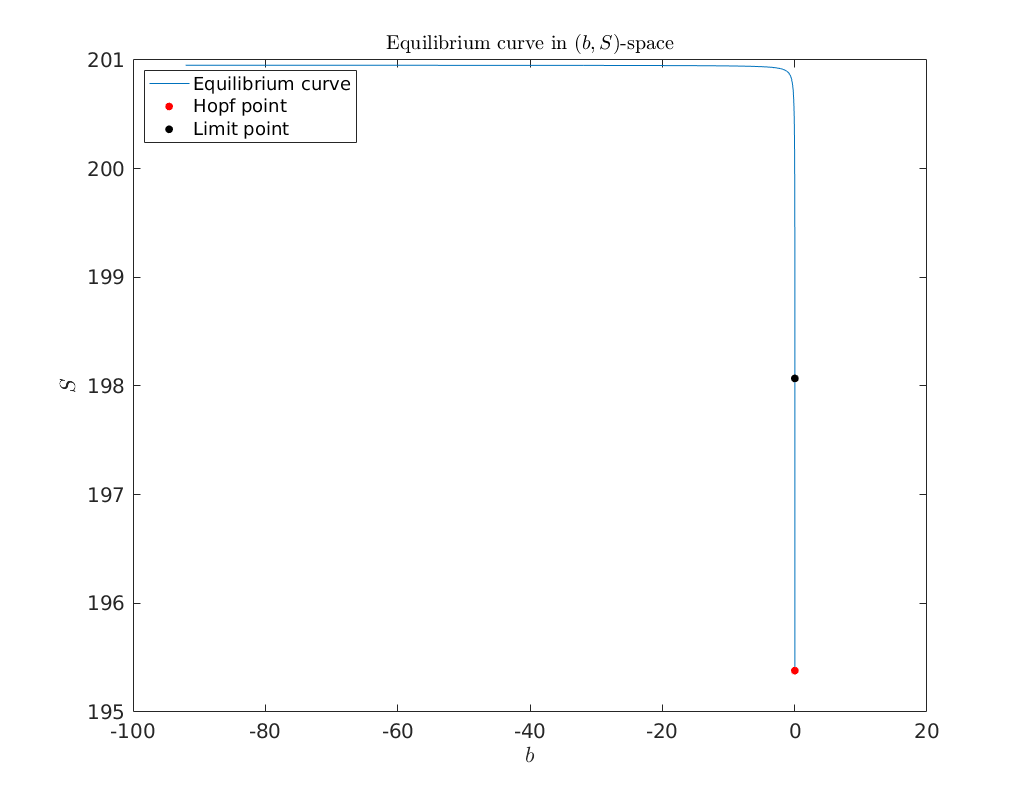

In [10]:
%plot --width 1024 --height 800
hopfPointInfo   = eqbr_bif_data(strcmp({eqbr_bif_data.msg}, 'Hopf')==1);
limitPointsInfo = eqbr_bif_data(strcmp({eqbr_bif_data.msg}, 'Limit point')==1);
HopfPoint1 = eqbr_x(:,hopfPointInfo.index);
limitpoint1 = eqbr_x(:,limitPointsInfo.index);
plot(eqbr_x(4,:), eqbr_x(1,:)); hold on
plot(HopfPoint1(4), HopfPoint1(1), '.r' ,'MarkerSize', 20)
plot(limitpoint1(4), limitpoint1(1),  '.k' ,'MarkerSize', 20)
xlabel('$b$')
ylabel('$S$')
legend({'Equilibrium curve', 'Hopf point', 'Limit point'}, 'Location', 'NorthWest')
title('Equilibrium curve in $(b,S)$-space', 'fontsize', 15)

## Continue Hopf point

We continue the Hopf point using again the function `cont`. We use the same
continuation options as defined above in the __struct__ `opt`.

In [11]:
hopf1.par = [mu1, b];
hopf1.par(ind.b) = eqbr_x(4, hopfPointInfo(1).index);
hopf1.x = eqbr_x(1:3, hopfPointInfo(1).index);
hopf1.x = x;
[hopf_x, hopf_v] = init_H_H(odefile, hopf1.x, hopf1.par', ap);
opt.MaxNumPoints = 500;
opt.MaxStepsize = .01;
opt.Singularities = 1;
[hopf_br, ~, hopf_br_bif] = cont(@hopf, hopf_x, hopf_v, opt);

first point found
tangent vector to first point found
label = GH, x = ( 195.599878 0.039046 3.970613 10.427886 0.025488 0.012691 )
l2=-8.624030e-05
> In nf_H (line 27)
In hopf>testf (line 150)
In cont>EvalTestFunc (line 810)
In cont (line 506)

> In nf_H (line 28)
In hopf>testf (line 150)
In cont>EvalTestFunc (line 810)
In cont (line 506)

label = BT, x = ( 198.059382 0.017026 1.753334 10.450822 0.033239 0.000000 )
(a,b)=(-1.298117e-03, 1.219168e-02)

elapsed time  = 1.3 secs
npoints curve = 500


## Continue homoclinic curve emanating from the Bogdanov-Takens point

To continue the homoclinic curve emanating from the Bogdanov-Takens point we
use the functions `BT_Hom_set_options` and `init_BT_Hom` to obtain an initial
approximation to the homoclinic solution (`hom_x`) as well as a tangent vector
to the discretized homoclinic solution (`hom_v`) as described in
{ref}`initial-prediction-Homoclinic-orbit`. 

In [12]:
bt_points_info = hopf_br_bif(strcmp({hopf_br_bif.label}, 'BT')==1);
bt.x = hopf_br(1:3, bt_points_info.index);
bt.par = hopf_br(4:5, bt_points_info.index);
BToptions = BT_Hom_set_options();
[hom_x, hom_v] = init_BT_Hom(odefile, bt,  ap, BToptions);
opt = contset;
opt.Singularities = 0;
homoclinic_br = cont(@homoclinic, hom_x, hom_v, opt);

Center manifold coefficients' accuracy: 7.460699e-13
BT normal form coefficients:
a=-1.298117e-03,	 b=1.219168e-02
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 0.524008
The initial half-return time T: 358.423
The initial distance eps0: 0.00239581
The initial distance eps1: 0.000941365
first point found
tangent vector to first point found

elapsed time  = 18.7 secs
npoints curve = 300


## Compare predicted with computed parameters 

Now that we have obtained a curve of homoclinic orbits (`homoclinic_br`) we
compare the computed curve in parameter space with the predicted curve we
construct below. To do so, we use the function `BT_nmfm_orbital` to obtain the
smooth orbital normal form coefficients, i.e. $a$ and $b$, and the coefficients
of the transformation $K$ between the parameters of the system and the parameters
of the smooth orbital normal form on the center manifold, see
{cite}`Bosschaert@2021`. We also plot the Hopf curve which can be compared with
Figure 4 in {cite}`Chunhua@2014`.

Center manifold coefficients' accuracy: 7.460699e-13


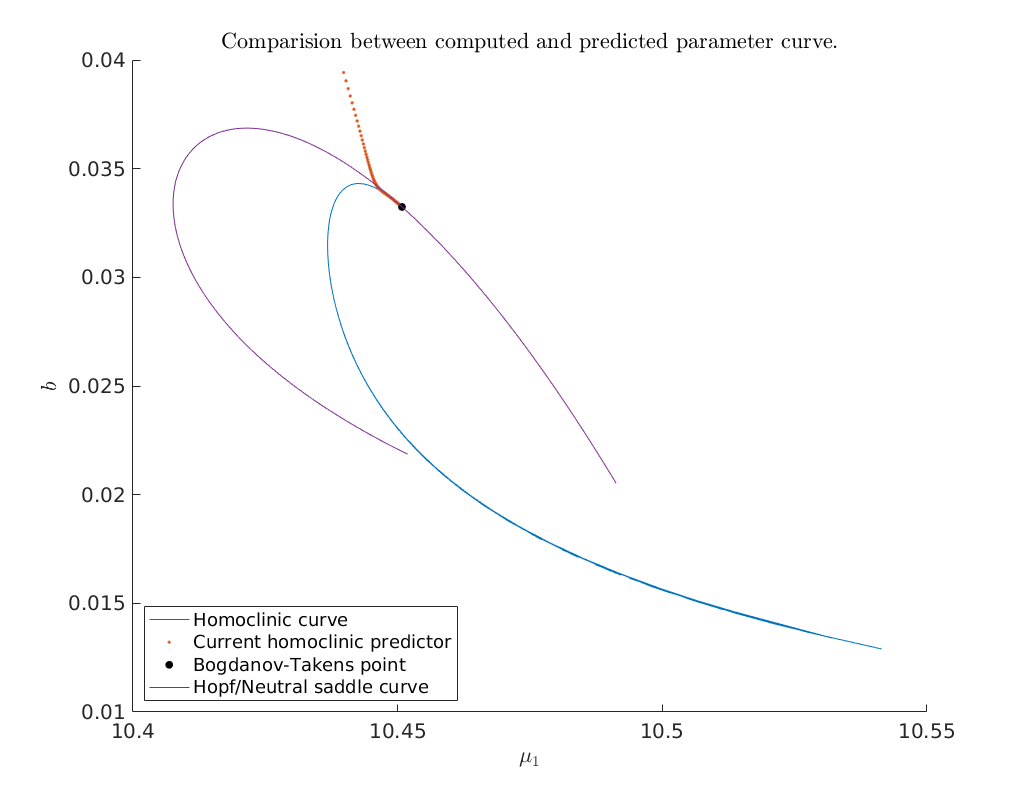

In [13]:
global homds
hold on
% plot computed homoclinic parameter curve
plot(homoclinic_br(homds.PeriodIdx+1,:), ...
     homoclinic_br(homds.PeriodIdx+2,:));
% Bogdanov-Takens parameter-dependent smooth orbital normal form coefficients
bt = BT_nmfm_orbital(odefile, bt, ap, BToptions);
a   = bt.nmfm.a;
b   = bt.nmfm.b;
K10 = bt.nmfm.K10;
K01 = bt.nmfm.K01;
K02 = bt.nmfm.K02;
K11 = bt.nmfm.K11;
K03 = bt.nmfm.K03;
% construct predictor as in the paper
eps = linspace(0, 0.3);
beta1 = -4*a^3/b^4*eps.^4;
tau0  = 10/7;
tau2  = 288/2401;
beta2 = a/b*(tau0 + tau2*eps.^2).*eps.^2;
alpha = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2 + 1/6*K03.*beta2.^3;
alpha = bt.par(ap) + alpha;
% plot currect predictor
plot(alpha(1,:), alpha(2,:), '.')
% plot Bogdanov-Takens point
plot(bt.par(ind.mu1), bt.par(ind.b), '.k', 'MarkerSize', 20)
plot(hopf_br(4,:), hopf_br(5,:))
% set axis labels and legend
xlabel('$\mu_1$')
ylabel('$b$')
legend({'Homoclinic curve', 'Current homoclinic predictor', ...
    'Bogdanov-Takens point', 'Hopf/Neutral saddle curve'}, 'Location', 'SouthWest')
title('Comparision between computed and predicted parameter curve.')

## Plot of continued homoclinic solutions in phase-space

To obtain an impression of the  homoclinic solutions we plot the computed
homoclinic orbits in $(S,I,R)$ phase-space.


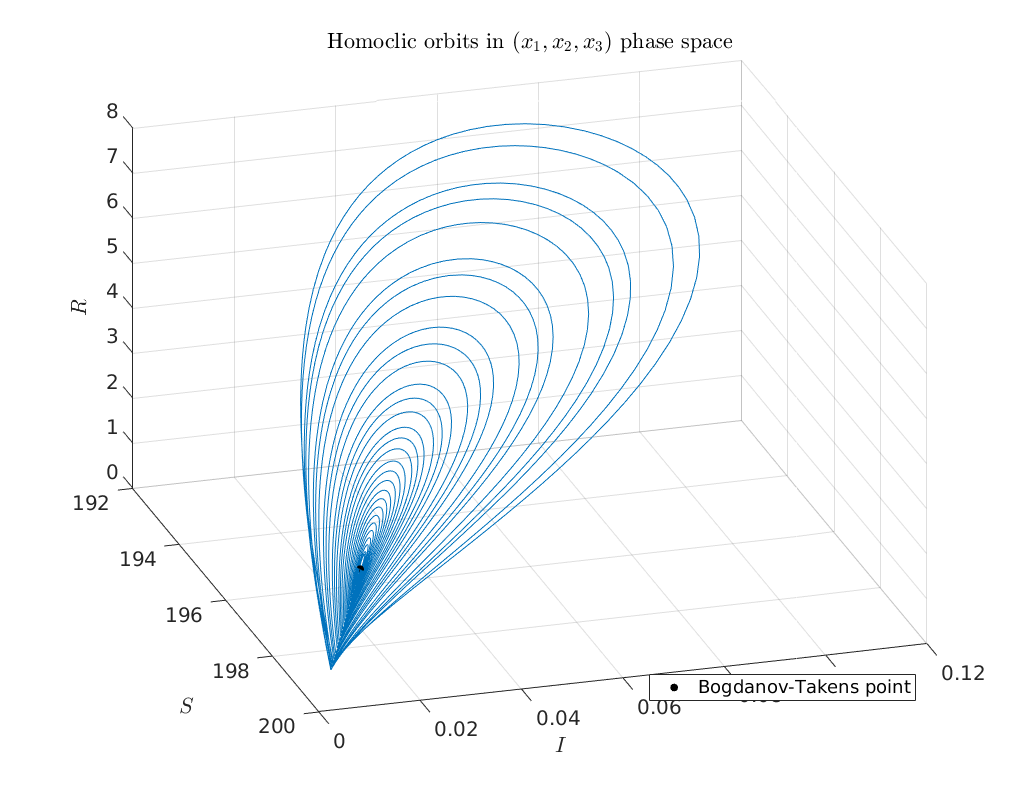

In [14]:
hold on
plot3(homoclinic_br(homds.coords(1:homds.nphase:end), 1:10:end), ...
      homoclinic_br(homds.coords(2:homds.nphase:end), 1:10:end), ...
      homoclinic_br(homds.coords(3:homds.nphase:end), 1:10:end), ...
     'Color', [0 0.4470 0.7410], 'HandleVisibility', 'Off')
xlabel('$S$')
ylabel('$I$')
zlabel('$R$')
plot3(bt.x(1), bt.x(2), bt.x(3), '.k' ,'MarkerSize', 20)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(x_1,x_2,x_3)$ phase space')
grid on
view([73, 33]);

### Predictors of orbits for various epsilons

Below we compute for a large range of amplitudes the predicted and corrected
homoclinic solutions and compare them in phase space. We see that even with an
amplitude of `1` the predicted homoclinic orbit is still relatively close.

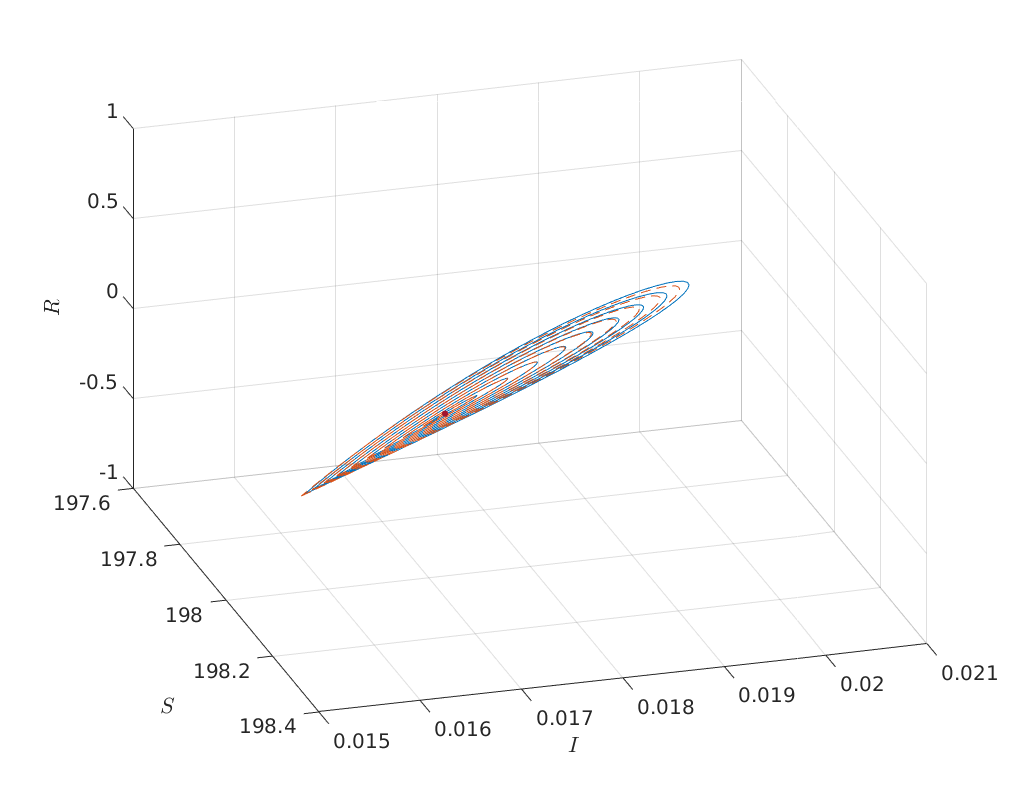

In [15]:
options = BT_Hom_set_options();
options.messages = false;
options.correct = false;
options.TTolerance = 1.0e-05;

amplitudes = linspace(1.0e-03, 1,10);
XPredicted = zeros(494,length(amplitudes));
XCorrected = zeros(494,length(amplitudes));
for j=1:length(amplitudes)
  options.amplitude = amplitudes(j);
  [x_pred, v0] = init_BT_Hom(odefile, bt, ap, options);
  XPredicted(:,j) = x_pred;
  try
    XCorrected(:,j) = newtcorr(x_pred, v0);
  catch
    warning('Didn''t convergence to homoclinic solution')
  end
end

hold on
cm = lines;
plot(XPredicted(homds.coords(1:homds.nphase:end),1:10), ...
     XPredicted(homds.coords(2:homds.nphase:end),1:10), ...
      'color', cm(1,:))
plot(XCorrected(homds.coords(1:homds.nphase:end),1:10), ...
     XCorrected(homds.coords(2:homds.nphase:end),1:10), ...
      '--', 'color', cm(2,:))
plot(bt.x(1), bt.x(2), '.', 'MarkerSize', 16)
xlabel('$S$')
ylabel('$I$')
zlabel('$R$')
grid on
view([73, 33]);

## Convergence plot

We finish this notebook with a log-log convergence plot comparing the different
third order homoclinic approximation methods derived in {cite}`Bosschaert@2021`
to approximate the homoclinic solutions near the first Bogdanov-Takens point.
On the abscissa is the amplitude $A_0$ and on the ordinate the relative error
$\delta$ between the constructed solution (`x_pred`) to the defining system for the
homoclinic orbit and the Newton corrected solution (`x_corrected`).

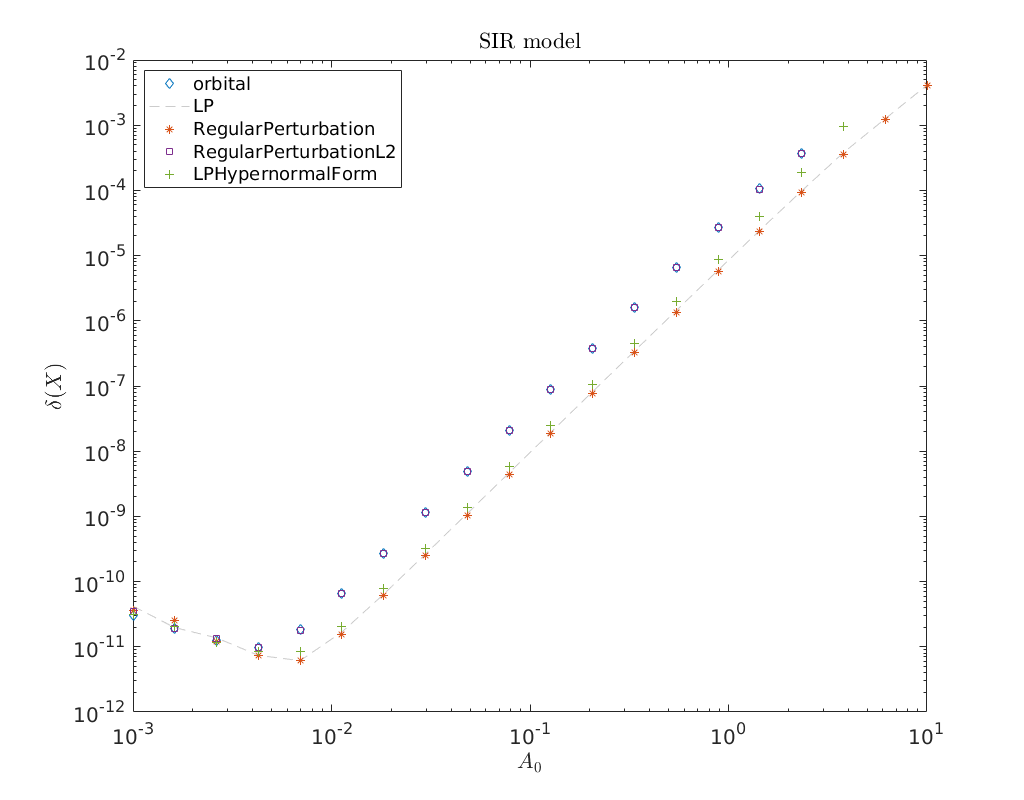

In [16]:
BToptions = BT_Hom_set_options();
BToptions.TTolerance = 1e-05;
BToptions.messages = false;
BToptions.correct = false;

amplitudes = logspace(-3, 1, 20);
methodList = {'orbital', 'LP', 'RegularPerturbation', ...
    'RegularPerturbationL2', 'LPHypernormalForm'};
relativeErrors = {};
for i=1:length(methodList)
    BToptions.method = methodList{i};
    relativeErrors{i} = zeros(size(amplitudes));
    for j=1:length(amplitudes)
    BToptions.amplitude = amplitudes(j);
    [x_pred, v0] = init_BT_Hom(odefile, bt, ap, BToptions);
    try
        x_corrected = newtcorr(x_pred, v0);
        relativeErrors{i}(j) = norm(x_corrected-x_pred)/norm(x_corrected);
    catch
        warning('Did not converge.')
        continue
    end
  end
end

cm = lines();
loglog(amplitudes, relativeErrors{1}(:), 'd', ...
       amplitudes, relativeErrors{2}(:), '--', ...
       amplitudes, relativeErrors{3}(:), '*', ...
       amplitudes, relativeErrors{4}(:), 's', ...
       amplitudes, relativeErrors{5}(:), '+')
legend(methodList, 'Location', 'NorthWest')
title('SIR model')
xlabel('$A_0$')
ylabel('$\delta(X)$')
ax = gca;
ax.ColorOrder = [cm(1,:); [0.8 0.8 0.8]; cm(2,:); cm(4,:); cm(5,:)];